# 1. Подготовка к работе.

In [1]:
import pandas as pd
import nltk
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
import re
import numpy as np
import warnings

from pymorphy2 import MorphAnalyzer
from tqdm import tqdm 
from datetime import datetime, date
from decimal import Decimal
from sklearn.utils import shuffle
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud
from pylab import rcParams
from IPython.display import HTML
from collections import Counter

In [2]:
plt.rcParams['figure.figsize'] = [20, 10]
plt.rc('ytick', labelsize=20) 
plt.rc('xtick', labelsize=20) 
sns.set_style("whitegrid")
colors = ["#BBBDFF","#EB825B"]
nltk.download("stopwords")
warnings.filterwarnings("ignore")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Александр\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Для анализа был собран набор данных из 2533 строк. 
По причне отказа Twitter в предоставлении API всем членам команды не удалось проверить возможность обойти ограничения API в семь дней. Однако с помощью библиотеки selenium удалось найти и собрать все необходимые данные.

Гипотеза №1 (есть возможность собрать данные из Twitter, минуя ограничение API в 7 дней) и Гипотеза №2 (есть возможность собрать данные из Twitter без использования API) подтверждены.

Использованный для парсинга код представлен в ноутбуке Parsing tweets from Twitter.ipynb (https://github.com/skillfactory-hackaton-team9/twitter-analyzer/blob/edf8d6d98df5f3b1ba37df2bf550b95a6d69385e/notebooks/Parsing%20tweets%20from%20Twitter.ipynb). Полученный набор данных twitter_new_raw_data.csv доступен по ссылке https://github.com/skillfactory-hackaton-team9/twitter-analyzer/blob/edf8d6d98df5f3b1ba37df2bf550b95a6d69385e/parsed_data/twitter_new_raw_data.csv .

In [3]:
parsed_df = pd.read_csv('https://raw.githubusercontent.com/skillfactory-hackaton-team9/twitter-analyzer/main/parsed_data/twitter.csv', index_col=0)
parsed_df.head()

,date,author,twitter_name,text,number_of_reply,number_of_retweets,number_of_likes
0,2016-10-30T10:16:12.000Z,Виталий Матросов,@vit_matrosov,"Тренинг ""Управление конфликтом"" @ Семинар ""Бла...",0,0,0
1,2016-10-25T07:52:13.000Z,Марцева Милана,@kp_milana,"На субботнике в фонде ""Подари жизнь""\n#субботн...",0,0,0
2,2016-10-20T21:51:02.000Z,Евгения Малеваная,@EjonokEvgenia,благотворительный фонд подари жизнь презентаци...,0,0,0
3,2016-10-20T08:31:43.000Z,Новости Улан-Удэ,@UlanUde_Novosti,Фонд «Подари мне жизнь» вручил подарки осужде...,0,0,0
4,2016-10-20T08:11:19.000Z,Новости России,@Russia_all_News,Фонд «Подари мне жизнь» вручил подарки осужден...,0,0,0


In [4]:
parsed_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1110 entries, 0 to 1109
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   date                1110 non-null   object
 1   author              1110 non-null   object
 2   twitter_name        1110 non-null   object
 3   text                1110 non-null   object
 4   number_of_reply     1110 non-null   int64 
 5   number_of_retweets  1110 non-null   int64 
 6   number_of_likes     1110 non-null   int64 
dtypes: int64(3), object(4)
memory usage: 69.4+ KB


C использованием моделей ('cointegrated/rubert-tiny-toxicity' (m1),'SkolkovoInstitute/russian_toxicity_classifier'(m2), 'cointegrated/rubert-tiny2-cedr-emotion-detection'(m3), 'Aniemore/rubert-tiny2-russian-emotion-detection' (m4)) было проведено изучение имеющихся твитов. Использование модели 'KoichiYasuoka/bert-base-russian-upos' позволило определить объекты в тексте.
Используемый код находится в ноутбуке по ссылке https://github.com/skillfactory-hackaton-team9/twitter-analyzer/blob/edf8d6d98df5f3b1ba37df2bf550b95a6d69385e/notebooks/%D0%A2%D0%B5%D0%BF%D0%BB%D0%B8%D1%86%D0%B0_%D1%81%D0%B5%D0%BD%D1%82%D0%B8%D0%BC%D0%B5%D0%BD%D1%82_%D0%B0%D0%BD%D0%B0%D0%BB%D0%B8%D0%B7_%D0%B2%D0%B5%D1%80%D1%81%D0%B8%D1%8F_2.ipynb.

Полученные результаты сохранены в csv файле sentiment_from_5_models.csv (https://github.com/skillfactory-hackaton-team9/twitter-analyzer/blob/edf8d6d98df5f3b1ba37df2bf550b95a6d69385e/parsed_data/sentiment_from_5_models.csv).

# 2. Очистка данных.

In [41]:
main_df = pd.read_csv('https://raw.githubusercontent.com/skillfactory-hackaton-team9/twitter-analyzer/main/parsed_data/sentiment_from_5_models.csv',index_col=0, sep=',')
main_df.head(5)

,date,author,twitter_name,text,number_of_reply,number_of_retweets,number_of_likes,m1_notoxic,m1_insult,m1_obscenity,...,m3_fear,m3_anger,m4_neutral,m4_happiness,m4_sadness,m4_enthusiasm,m4_fear,m4_anger,m4_disgust,m5_objects
0,2022-07-22T20:22:11.000Z,Светлана,@Svetlan99809534,по оценке журнала «Forbes» Керимов стал третьи...,0,0,0,0.999206,0.000774,0.000202,...,0.005459,0.005077,0.987943,0.005911,0.007564,0.005373,0.005333,0.005620,0.003407,керимов жизнь горчакова forbes россии фонд фон...
1,2022-07-18T12:17:28.000Z,Серж,@eATOuWB6hfHqVpc,Хаматова в свой фонд подари жизнь по 1млрд в г...,0,0,4,0.969807,0.032301,0.001154,...,0.004878,0.020253,0.043987,0.348249,0.180201,0.023196,0.002875,0.206812,0.010694,хаматова
2,2022-07-04T05:47:11.000Z,ленаelena,@elena53166542,У Хаматовой денег море. Она обокрал фонд Подар...,2,0,1,0.999454,0.000700,0.000134,...,0.005141,0.005481,0.982843,0.005219,0.011761,0.004467,0.005009,0.005505,0.003115,хаматовой
3,2022-07-02T19:22:11.000Z,Dre1,@DremanerDre1,"Мих, ты не ""Лёняверим"", может кто-либо из твои...",0,0,0,0.999337,0.000653,0.000186,...,0.006284,0.011269,0.697096,0.006642,0.005628,0.087352,0.013222,0.145647,0.007568,лёняверим спартак мих
4,2022-07-01T18:44:57.000Z,"Wishmaster© Vendetta,",–,Дебиторская задолженность фонда «Подари жизнь»...,0,1,3,0.998452,0.001748,0.000132,...,0.004534,0.005451,0.985294,0.005397,0.008487,0.005297,0.004396,0.005548,0.003071,чулпан хаматовой эдвард чесноков


In [42]:
main_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2533 entries, 0 to 2532
Data columns (total 28 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   date                2533 non-null   object 
 1   author              2533 non-null   object 
 2   twitter_name        2533 non-null   object 
 3   text                2533 non-null   object 
 4   number_of_reply     2533 non-null   int64  
 5   number_of_retweets  2533 non-null   int64  
 6   number_of_likes     2533 non-null   int64  
 7   m1_notoxic          2533 non-null   float64
 8   m1_insult           2533 non-null   float64
 9   m1_obscenity        2533 non-null   float64
 10  m1_threat           2533 non-null   float64
 11  m1_dangerous        2533 non-null   float64
 12  m2_neutral          2533 non-null   float64
 13  m2_toxic            2533 non-null   float64
 14  m3_no_emotion       2533 non-null   float64
 15  m3_joy              2533 non-null   float64
 16  m3_sad

In [43]:
main_df['date_type'] = pd.to_datetime(main_df.date) # колонка для технических потребностей, будет удалена
main_df["week"] = main_df["date_type"].to_numpy().astype("datetime64[W]") # для визуализации
main_df["r"] = 1 #дополнительная информация для группировки
main_df['date'] = main_df['date'].apply(lambda x: x.split('T')[0])
main_df['date'] = main_df['date'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d').strftime("%Y"))

main_df.head(2)

,date,author,twitter_name,text,number_of_reply,number_of_retweets,number_of_likes,m1_notoxic,m1_insult,m1_obscenity,...,m4_happiness,m4_sadness,m4_enthusiasm,m4_fear,m4_anger,m4_disgust,m5_objects,date_type,week,r
0,2022,Светлана,@Svetlan99809534,по оценке журнала «Forbes» Керимов стал третьи...,0,0,0,0.999206,0.000774,0.000202,...,0.005911,0.007564,0.005373,0.005333,0.005620,0.003407,керимов жизнь горчакова forbes россии фонд фон...,2022-07-22 20:22:11+00:00,2022-07-21,1
1,2022,Серж,@eATOuWB6hfHqVpc,Хаматова в свой фонд подари жизнь по 1млрд в г...,0,0,4,0.969807,0.032301,0.001154,...,0.348249,0.180201,0.023196,0.002875,0.206812,0.010694,хаматова,2022-07-18 12:17:28+00:00,2022-07-14,1


<AxesSubplot:>

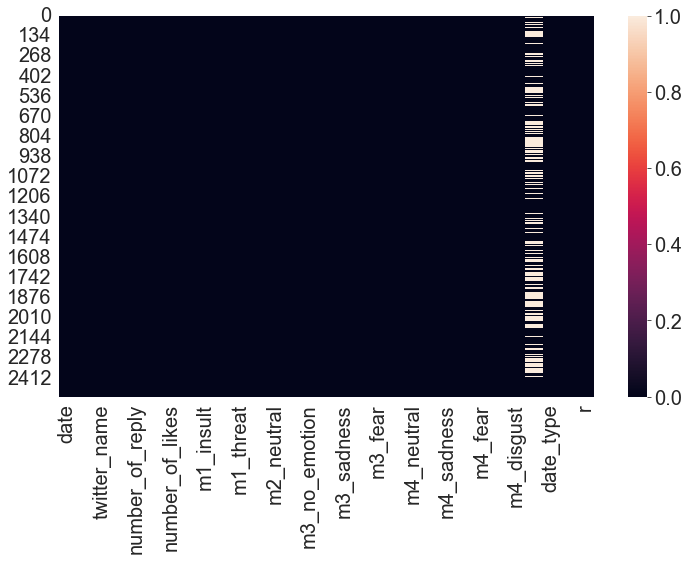

In [44]:
plt.subplots(figsize=(12, 7))
sns.heatmap(main_df.isnull())

In [45]:
# для дальнейшего подсчета
main_df.m5_objects.fillna('пропуск', inplace=True)

In [46]:
main_df = shuffle(main_df)
main_df.reset_index(inplace=True, drop=True)
main_df.head(2)

,date,author,twitter_name,text,number_of_reply,number_of_retweets,number_of_likes,m1_notoxic,m1_insult,m1_obscenity,...,m4_happiness,m4_sadness,m4_enthusiasm,m4_fear,m4_anger,m4_disgust,m5_objects,date_type,week,r
0,2015,Виктория Свиридова,@vika3221,История одного выздоровления! Надежда есть все...,0,1,1,0.999779,0.000294,0.000108,...,0.924146,0.065986,0.005932,0.013636,0.014976,0.005915,пропуск,2015-03-13 11:52:57+00:00,2015-03-12,1
1,2013,Другие Вести,@ddb777,Помочь детям просто: http://podari-zhizn.ru/ma...,0,2,1,0.999763,0.000218,0.000097,...,0.020298,0.065080,0.021450,0.010587,0.395107,0.011660,пропуск,2013-06-04 09:32:30+00:00,2013-05-30,1


## 2.1. Предобработка текста.

In [47]:
def clear_text(text):
    clear_text = re.sub(r'[^А-яЁё]+', ' ', text).lower()
    return ' '.join(clear_text.split())

In [48]:
main_df['clean_text'] = main_df['text'].apply(clear_text)
main_df['m5_objects'] = main_df['m5_objects'].apply(clear_text)
main_df.head(2)

,date,author,twitter_name,text,number_of_reply,number_of_retweets,number_of_likes,m1_notoxic,m1_insult,m1_obscenity,...,m4_sadness,m4_enthusiasm,m4_fear,m4_anger,m4_disgust,m5_objects,date_type,week,r,clean_text
0,2015,Виктория Свиридова,@vika3221,История одного выздоровления! Надежда есть все...,0,1,1,0.999779,0.000294,0.000108,...,0.065986,0.005932,0.013636,0.014976,0.005915,пропуск,2015-03-13 11:52:57+00:00,2015-03-12,1,история одного выздоровления надежда есть всег...
1,2013,Другие Вести,@ddb777,Помочь детям просто: http://podari-zhizn.ru/ma...,0,2,1,0.999763,0.000218,0.000097,...,0.065080,0.021450,0.010587,0.395107,0.011660,пропуск,2013-06-04 09:32:30+00:00,2013-05-30,1,помочь детям просто фонд подари жизнь


In [49]:
def clean_stop_words(text : str):
    stop = stopwords.words('russian')
    stop.extend(['что', 'это', 'так', 'вот', 'быть', 'как', 'в', '—', '–', 'к', 'на', '...', '>', 'донорыдеть'])
    text = [word for word in text.split() if word not in stop]
    return " ".join(text)

In [50]:
main_df['clean_text'] = main_df['clean_text'].apply(clean_stop_words)
main_df.head(2)

,date,author,twitter_name,text,number_of_reply,number_of_retweets,number_of_likes,m1_notoxic,m1_insult,m1_obscenity,...,m4_sadness,m4_enthusiasm,m4_fear,m4_anger,m4_disgust,m5_objects,date_type,week,r,clean_text
0,2015,Виктория Свиридова,@vika3221,История одного выздоровления! Надежда есть все...,0,1,1,0.999779,0.000294,0.000108,...,0.065986,0.005932,0.013636,0.014976,0.005915,пропуск,2015-03-13 11:52:57+00:00,2015-03-12,1,история одного выздоровления надежда фонд пода...
1,2013,Другие Вести,@ddb777,Помочь детям просто: http://podari-zhizn.ru/ma...,0,2,1,0.999763,0.000218,0.000097,...,0.065080,0.021450,0.010587,0.395107,0.011660,пропуск,2013-06-04 09:32:30+00:00,2013-05-30,1,помочь детям просто фонд подари жизнь


In [51]:
morph = MorphAnalyzer()
main_df['clean_text'] = main_df['clean_text'].apply(lambda x: morph.normal_forms(x)[0])
main_df['m5_objects'] = main_df['m5_objects'].apply(lambda x: morph.normal_forms(x)[0])
main_df.head(2)

,date,author,twitter_name,text,number_of_reply,number_of_retweets,number_of_likes,m1_notoxic,m1_insult,m1_obscenity,...,m4_sadness,m4_enthusiasm,m4_fear,m4_anger,m4_disgust,m5_objects,date_type,week,r,clean_text
0,2015,Виктория Свиридова,@vika3221,История одного выздоровления! Надежда есть все...,0,1,1,0.999779,0.000294,0.000108,...,0.065986,0.005932,0.013636,0.014976,0.005915,пропуск,2015-03-13 11:52:57+00:00,2015-03-12,1,история одного выздоровления надежда фонд пода...
1,2013,Другие Вести,@ddb777,Помочь детям просто: http://podari-zhizn.ru/ma...,0,2,1,0.999763,0.000218,0.000097,...,0.065080,0.021450,0.010587,0.395107,0.011660,пропуск,2013-06-04 09:32:30+00:00,2013-05-30,1,помочь детям просто фонд подари жизнь


In [52]:
#Add new feature to DF 'text_lengh'
main_df['text_lengh'] = main_df['clean_text'].apply(lambda x: len(x.strip(' ')))
main_df.head(2)

,date,author,twitter_name,text,number_of_reply,number_of_retweets,number_of_likes,m1_notoxic,m1_insult,m1_obscenity,...,m4_enthusiasm,m4_fear,m4_anger,m4_disgust,m5_objects,date_type,week,r,clean_text,text_lengh
0,2015,Виктория Свиридова,@vika3221,История одного выздоровления! Надежда есть все...,0,1,1,0.999779,0.000294,0.000108,...,0.005932,0.013636,0.014976,0.005915,пропуск,2015-03-13 11:52:57+00:00,2015-03-12,1,история одного выздоровления надежда фонд пода...,54
1,2013,Другие Вести,@ddb777,Помочь детям просто: http://podari-zhizn.ru/ma...,0,2,1,0.999763,0.000218,0.000097,...,0.021450,0.010587,0.395107,0.011660,пропуск,2013-06-04 09:32:30+00:00,2013-05-30,1,помочь детям просто фонд подари жизнь,37


# 3. Sentiment-анализ.

## 3.1. Результативность моделей. 

Для определения результативности моделей нужно проверить, насколько хорошо они определяют зявленные признаки.

In [53]:
def show_column_info(column_name, ascending=False):
    top_tweets = main_df.sort_values(column_name, ascending=ascending)
    show_tweets(top_tweets, 10, column_name)

In [54]:
# функция для демонстрации выбранных твитов
def show_tweets(tweets, count=10, title=""):
    if(title):
        display(HTML(f"<h3>{title}</h3>"))
    for t in tweets.text.head(count):
        display(HTML(f"<li>{t}</li>"))

In [55]:
for column in [col for col in main_df.columns if col.startswith("m")]:
    show_column_info(column)

Выводы по анализу топовых твитов в каждой модели:
m1_notoxic - хорошо определяет токсичные комментарии
m1_insult - хорошо определяет оскорбления
m1_obscenity - плохо, должен определять непристойности
m1_threat - угрозы, не очень понятно, часто ошибается
m1_dangerous - тоже неплохо определяет твиты, которые токсичные
m2_toxic -  хорошо определяет токсичные твиты
m3_joy - определяет радостные твиты, хорошо
m3_sadness - определяет грустные твиты, хорошо
m3_surprise - определяет удивление, не понятно, кажется не очень
m3_fear - страх, плохо
m3_anger - гнев, хорошо
m4_hapiness - счаастливые твиты, хорошо
m4_sadness - грустные твиты, хорошо
m4_enthusiasm - твиты с энтузиазмом, плохо
m4_fear - страх, плохо
m4_anger - гнев, плохо
m4_disqust - отвращение, плохо

В дальнейшей работе будут использоваться данные наиболее хорошо себя проявивших показателей m1_notoxic и m2_toxic

## 3.2. Опередилим для дальнейшей работы токсичные комментарии.

#### Предсказания первой модели

In [56]:
TOXIC_THRESHOLD = 0.9
main_df["is_toxic1"] = (main_df.m1_notoxic  < TOXIC_THRESHOLD).astype(int)

In [57]:
show_tweets(main_df.loc[main_df.is_toxic1 == 1], title="Токсичные твиты 1")

#### Предсказания второй модели

In [58]:
TOXIC_THRESHOLD = 0.2
main_df["is_toxic2"] = (main_df.m2_toxic  > TOXIC_THRESHOLD).astype(int)

In [59]:
show_tweets(main_df.loc[main_df.is_toxic2 == 1], title="Токсичные твиты 2")

#### Общие предсказания

In [60]:
main_df["is_toxic"] = ((main_df.is_toxic1 == 1) | (main_df.is_toxic2 == 1)).astype(int)

show_tweets(main_df.loc[main_df.is_toxic == 1], title="Токсичные твиты 3")

In [61]:
show_tweets(main_df.loc[main_df.is_toxic == 0], title="Нормальные твиты")

Полученная колонка main_df.is_toxic позволяет достаточно хорошо выявить токсичные твиты, поэтому будет использована для дальнейшего анализа данных

## 3.3. Распределение токсичности твитов во времени.

In [62]:
plot_data = pd.DataFrame(main_df.groupby(["week", "is_toxic"]).r.count())

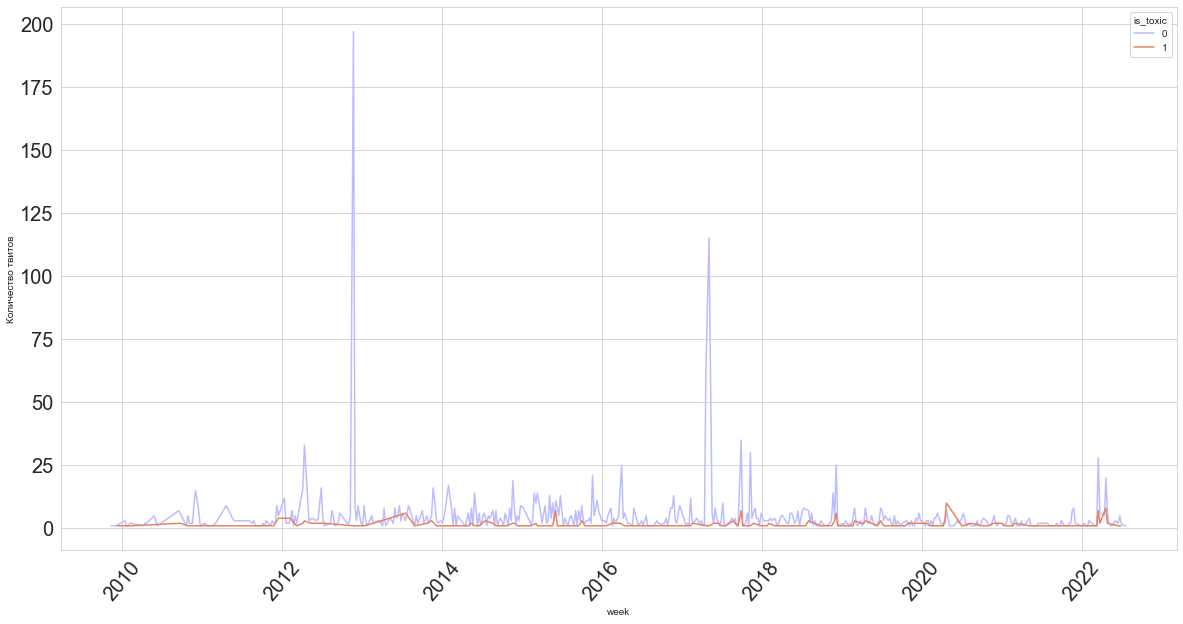

In [63]:
sns.lineplot(data=plot_data, x="week", y="r", hue="is_toxic", palette=colors);
plt.xticks(rotation=50)
plt.ylabel("Количество твитов")
plt.show()

In [64]:
plot_data.sort_values("r", ascending=False).head(3)

,,r
week,is_toxic,
2012-11-22,0,197
2017-05-04,0,115
2017-04-20,0,63


В наборе данных выделяется три резких увеличения по  количеству сообщений за неделю.

In [65]:
show_tweets(main_df.loc[main_df.week == '2012-11-22'], title="Ноябрь 2012")

In [66]:
show_tweets(main_df.loc[main_df.week == '2017-05-04'], title="Май 2017")

In [67]:
show_tweets(main_df.loc[main_df.week == '2017-04-20'], title="Апрель 2017")

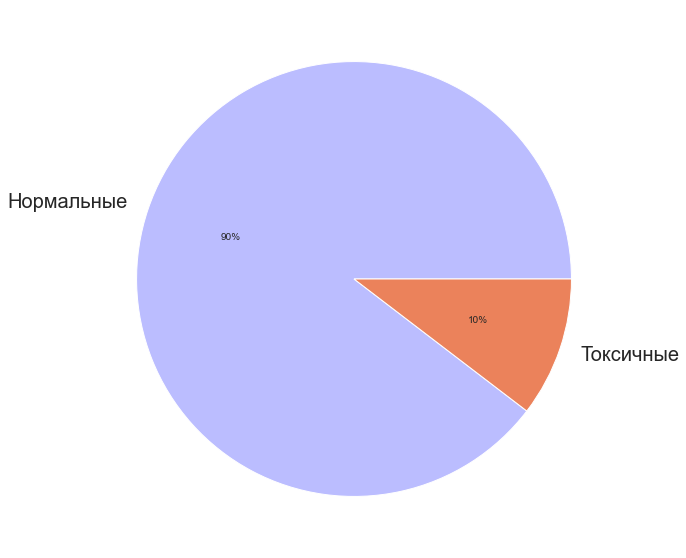

In [68]:
plt.pie(main_df.is_toxic.value_counts(), labels = ["Нормальные","Токсичные"], colors=colors, autopct='%.0f%%')
plt.show()

In [69]:
main_df['is_toxic'].value_counts()

0    2270
1     263
Name: is_toxic, dtype: int64

#### Выводы:
Количество комментариев примерно равномерное, но бывают всплески

На несколько недель выпали какие-то массовые рассылки, и они выделяются по количеству сообщений в неделю.

По оценкам наших моделей, токсичных комментариев где-то 10% от общего числа (но это определяется порогом, и может быть изменено). Но, в любом случае, таких отзывов большинство. Гипотезу №3 можно считать подтвержденной.

## 3.4. Удаление лишних столбцов

In [70]:
main_df.drop(columns=["m1_notoxic", "m1_insult", "m1_obscenity", "m1_threat", "m1_dangerous",  "m2_neutral", "m2_toxic", "m3_no_emotion", "m3_joy", "m3_sadness", "m3_surprise", "m3_fear", "m3_anger", 'm4_neutral', 'm4_happiness', 'm4_sadness', 'm4_enthusiasm', 'm4_fear', 'm4_anger', 'm4_disgust', 'date_type', 'is_toxic1', 'is_toxic2'], inplace=True)
main_df.head(2)

,date,author,twitter_name,text,number_of_reply,number_of_retweets,number_of_likes,m5_objects,week,r,clean_text,text_lengh,is_toxic
0,2015,Виктория Свиридова,@vika3221,История одного выздоровления! Надежда есть все...,0,1,1,пропуск,2015-03-12,1,история одного выздоровления надежда фонд пода...,54,0
1,2013,Другие Вести,@ddb777,Помочь детям просто: http://podari-zhizn.ru/ma...,0,2,1,пропуск,2013-05-30,1,помочь детям просто фонд подари жизнь,37,0


# 4. Частотный анализ.

## 4.1. Упоминания фонда.

In [71]:
main_df.twitter_name.value_counts().head(10)

@orangevyy        59
@5tv              34
@hotpies8         18
@tvc_ru           15
@Zoombyru_News    13
@tvcplus          12
@miloserdie_ru    11
@Lednikova_L      10
@wsewmeste         9
@danilovcydd       9
Name: twitter_name, dtype: int64

Обычно люди упоминают Фонд "Подари жизнь" не очень часто (Только в твитах 8 пользователей  фод упомянут 10 и более раз). 

In [72]:
main_df.author.value_counts().head(10)

ар2дэ2                  59
Пятый канал Новости     34
hotpies8                18
ТВ Центр                15
Новости на Zoomby.ru    13
TVC News                12
miloserdie_ru           11
Oля                     10
Волонтеры Даниловцы      9
Помогаем Все вместе      9
Name: author, dtype: int64

In [73]:
main_df.drop(columns=['author','twitter_name'], inplace=True)

Из восьми указанных выше пользователей только трое являются физическими лицами (@orangevyy, @hotpies8, @Lednikova_L). Остальные являются СМИ или тематическими группами

## 4.2. Частотный анализ на всем объеме данных.

In [116]:
Twitter = CountVectorizer(ngram_range=(1, 1))
Twitter_count = Twitter.fit_transform(main_df['clean_text'])
Twitter_frequence = pd.DataFrame({'word':Twitter.get_feature_names(),'frequency':np.array(Twitter_count.sum(axis = 0))[0]}).sort_values(by = 'frequency', ascending = False)
Twitter_frequence_main = Twitter_frequence[:100]

In [117]:
wordcloud_Twitter = WordCloud(background_color="black",
                               colormap = 'Blues',
                               max_words=200,
                               mask=None, 
                               width=1600,
                               height=1600)\
                        .generate_from_frequencies(
                            dict(Twitter_frequence_main.values))

In [118]:
Twitter_frequence_main['percent'] = Twitter_frequence_main['frequency'].apply(lambda x: x/(Twitter_frequence_main['frequency'].sum()/100))
Twitter_frequence_main[:10]

,word,frequency,percent
6531,фонд,2419,17.573556
1600,жизнь,2394,17.391936
4096,подари,2374,17.246640
315,благотворительный,396,2.876862
6804,чулпан,243,1.765347
4097,подарижизнь,233,1.692699
2510,лечение,199,1.445696
4313,получит,192,1.394842
1258,детский,190,1.380312
6642,хоспис,185,1.343988


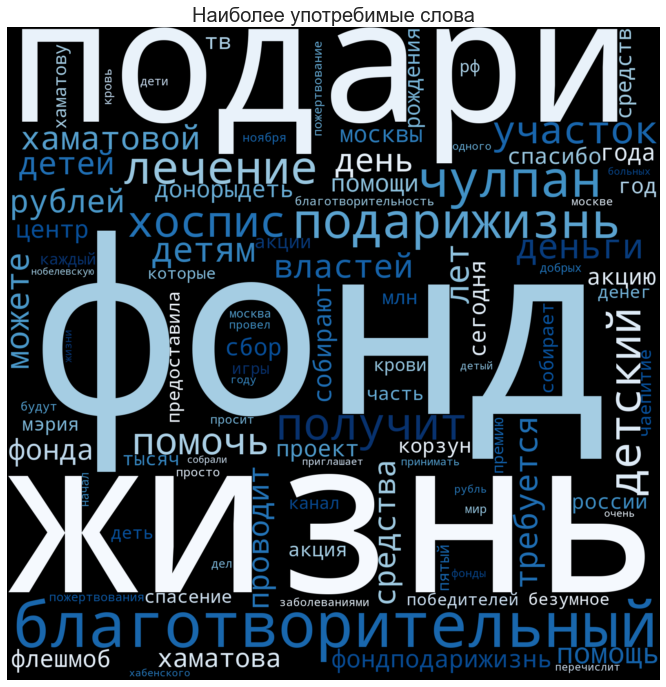

In [119]:
fig, ax = plt.subplots(1, figsize = (20, 12))

ax.imshow(wordcloud_Twitter, interpolation='bilinear')
ax.set_title('Наиболее употребимые слова', fontsize = 20)
ax.axis("off")

plt.show()

Исходя из списка наиболее используемых слов и представленного выше облака слов, можно сделать вывод о том, что основная тематика сообщений связана с деятельностью фонда. Гипотезу №6 можно считать доказанной.

## 4.3. Частотный анализ негативных твитов.

In [120]:
neg_df = main_df.loc[main_df['is_toxic']==1]

In [121]:
Twitter_neg = CountVectorizer(ngram_range=(1, 1))
Twitter_count_neg = Twitter_neg.fit_transform(neg_df['clean_text'])
Twitter_frequence_neg = pd.DataFrame({'word':Twitter_neg.get_feature_names(),'frequency':np.array(Twitter_count_neg.sum(axis = 0))[0]}).sort_values(by = 'frequency', ascending = False)
Twitter_frequence_main_neg = Twitter_frequence_neg[:10]

In [122]:
wordcloud_Twitter_neg = WordCloud(background_color="black",
                               colormap = 'Reds',
                               max_words=200,
                               mask=None, 
                               width=1600,
                               height=1600)\
                        .generate_from_frequencies(
                            dict(Twitter_frequence_main_neg.values))

In [123]:
Twitter_frequence_main_neg['percent'] = Twitter_frequence_main_neg['frequency'].apply(lambda x: x/(Twitter_frequence_main['frequency'].sum()/100))
chulpan = ['чулпан', 'хаматовый', 'хаматовой', 'хаматов', 'хаматова', 'хаматову']
korzun = ['дин', 'корзун']
Twitter_frequence_main_neg['word'] = Twitter_frequence_main_neg['word'].apply(lambda x: 'чулпан' if x in chulpan else x)
Twitter_frequence_main_neg['word'] = Twitter_frequence_main_neg['word'].apply(lambda x: 'корзун' if x in korzun else x)
Twitter_frequence_main_neg.groupby(['word']).sum()

,frequency,percent
word,,
деньги,23,0.167090
детей,22,0.159826
жизнь,234,1.699964
подари,228,1.656375
подарижизнь,29,0.210679
фонд,227,1.649110
фондподарижизнь,22,0.159826
чулпан,125,0.908100


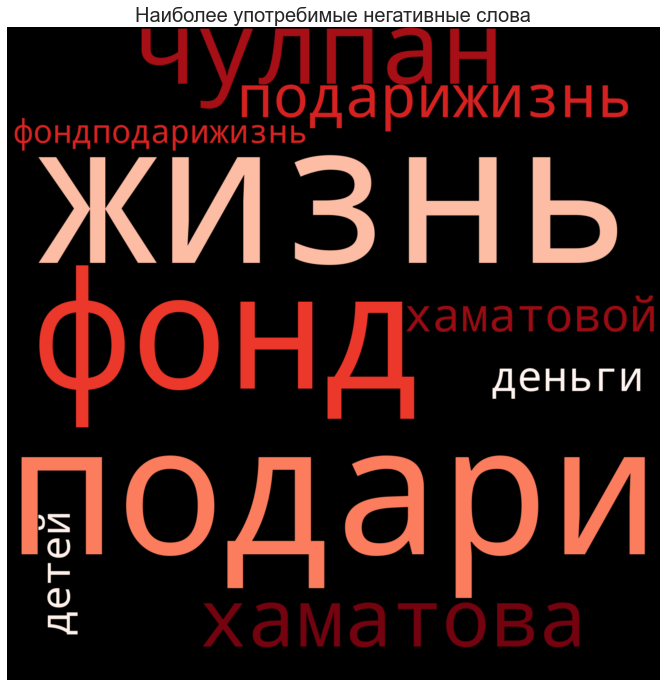

In [124]:
fig, ax = plt.subplots(1, figsize = (20, 12))

ax.imshow(wordcloud_Twitter_neg, interpolation='bilinear')
ax.set_title('Наиболее употребимые негативные слова', fontsize = 20)
ax.axis("off")

plt.show()

In [125]:
neg_plot_data = pd.DataFrame(neg_df.groupby(["week"]).r.count())

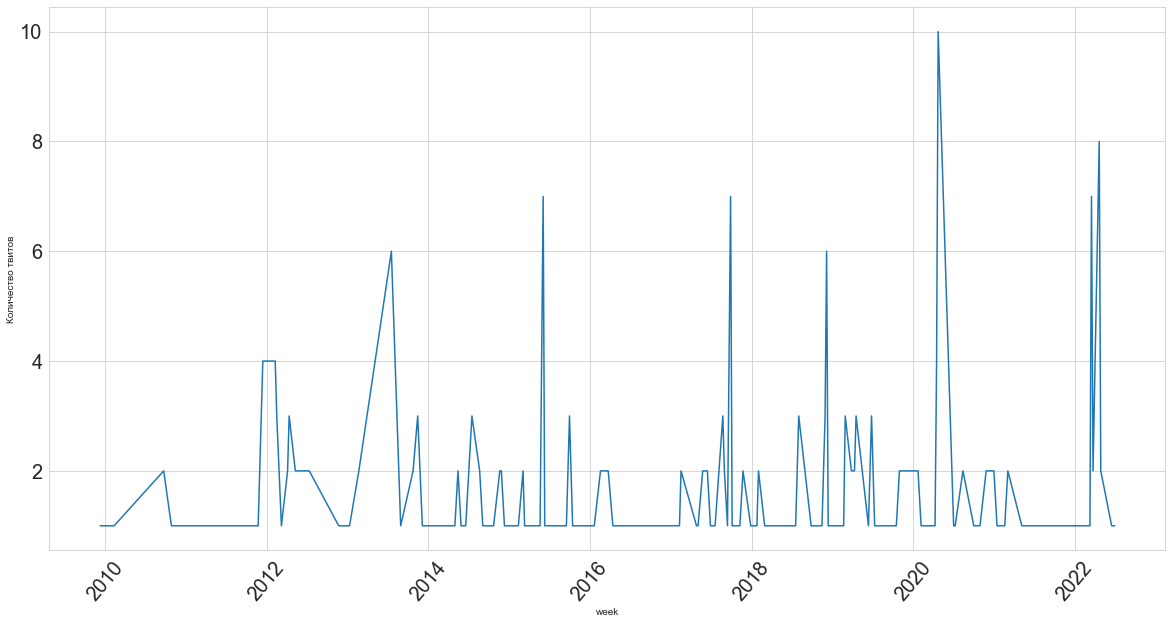

In [126]:
sns.lineplot(data=neg_plot_data, x="week", y="r", palette=colors);
plt.xticks(rotation=50)
plt.ylabel("Количество твитов")
plt.show()

#### Число негативных отзывов после пика 2018 года снижалось до 2021 года. В 2022 году веден стремительный рост числа негативных отзывов. Видны ярко выраженные всплески, которые требуется проанализировать.

In [127]:
neg_plot_data.sort_values("r", ascending=False).head(3)

,r
week,
2020-04-23,10
2022-04-21,8
2022-03-17,7


In [128]:
show_tweets(neg_df.loc[neg_df.week == '2020-04-23'], title="Апрель 2020")

In [129]:
show_tweets(neg_df.loc[neg_df.week == '2022-04-21'], title="Апрель 2022")

In [130]:
show_tweets(neg_df.loc[neg_df.week == '2022-03-17'], title="Март 2022")

#### Анализ негативных отзывов за последнее время показывает, что негативные отзывы, по-преимуществу, связаны с политической и культурной позицией учредителя фонда Чулпан Хаматовой и не имеют никакого отношения к деятельности фонда. Также имеет весомое значение дебиторская задолженность Фонда в размере 1 млрд рублей за 2021 год.

In [131]:
all_list = Twitter_frequence_main['word'].tolist()

In [132]:
neg_list = Twitter_frequence_main_neg['word'].tolist()
len(neg_list)

10

In [133]:
both_words = []
for x in neg_list:
    if x in all_list:
        all_list.remove(x)
        neg_words.append(x)
    else:
        continue
len(all_list)

92

In [134]:
both_words

['жизнь',
 'подари',
 'фонд',
 'чулпан',
 'подарижизнь',
 'деньги',
 'детей',
 'фондподарижизнь']

#### 92 слов из 100 в списке наиболее употребимых относятся к положительным. Гипотезу №4 (наиболее употребимые слова связаны с деятельностью фонда и носят позитивный характер) можно считать подтвержденной.

## 4.4. Частотный анализ позитивных твитов.

#### В связи с тем, что позитивные отзывы составляют подавляющее большинство, то результат будет мало отличаться от представленного выше анализа данных в целом. Их отдельный детальный анализ не требуется. Но требуется уточнить основную тематику.

In [137]:
pos_df = main_df.loc[main_df['is_toxic']==0]

In [138]:
pos_plot_data = pd.DataFrame(pos_df.groupby(["week"]).r.count())

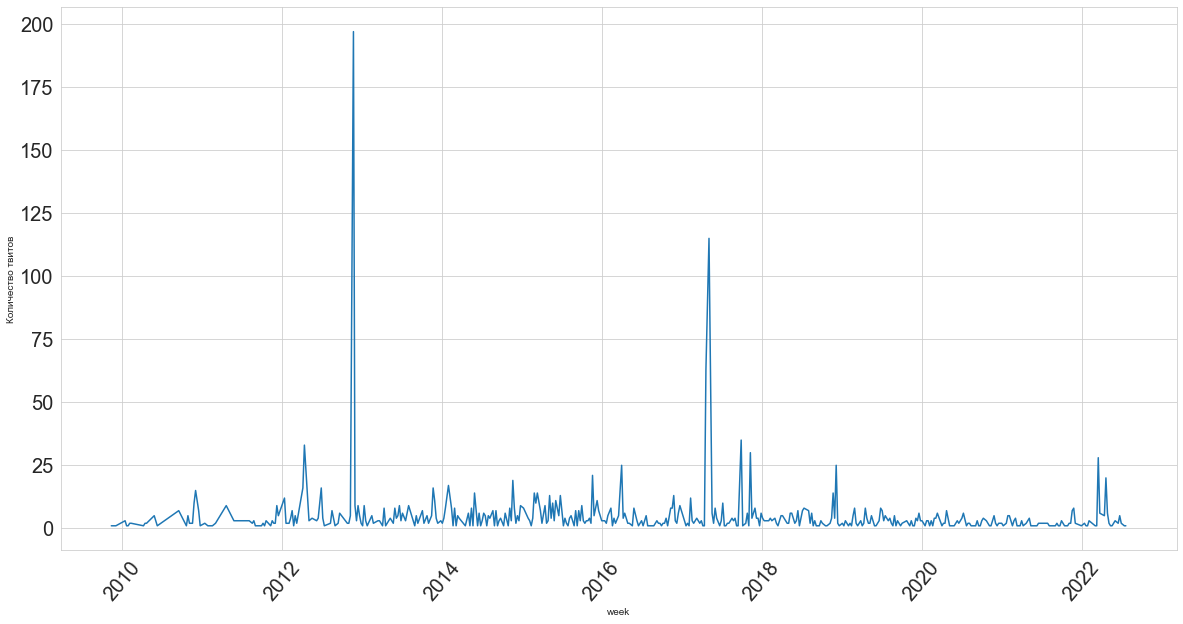

In [139]:
sns.lineplot(data=pos_plot_data, x="week", y="r", palette=colors);
plt.xticks(rotation=50)
plt.ylabel("Количество твитов")
plt.show()

In [140]:
pos_plot_data.sort_values("r", ascending=False).head(7)

,r
week,
2012-11-22,197
2017-05-04,115
2017-04-20,63
2017-09-28,35
2012-04-12,33
2017-11-09,30
2022-03-17,28


In [141]:
show_tweets(neg_df.loc[neg_df.week == '2022-03-17'], title="Март 2020")

#### Число позитивных твитов неуклонно снижается. 
Основные пики, вызванные рассылкой, были проанализированы ранее.Однако всплеск позитивных твитов в 2022 году, как и рост числа негативных, не является следствием изменения объективного интереса к деятельности фонда, так как представленные выше сообщения о ней практически не упоминают. Вероятно, причиной послужило интервью, которое в марте  Чулпан Хаматова дала Гордеевой. 

## 4.5. Частотный анализ объектов.

In [142]:
Twitter_object = CountVectorizer(ngram_range=(1, 1))
Twitter_count_object = Twitter_object.fit_transform(main_df['m5_objects'])
Twitter_frequence_object = pd.DataFrame({'word':Twitter_object.get_feature_names(),'frequency':np.array(Twitter_count_object.sum(axis = 0))[0]}).sort_values(by = 'frequency', ascending = False)
Twitter_frequence_main_object = Twitter_frequence_object[:100]

In [143]:
wordcloud_Twitter = WordCloud(background_color="black",
                               colormap = 'Blues',
                               max_words=200,
                               mask=None, 
                               width=1600,
                               height=1600)\
                        .generate_from_frequencies(
                            dict(Twitter_frequence_main_object.values))

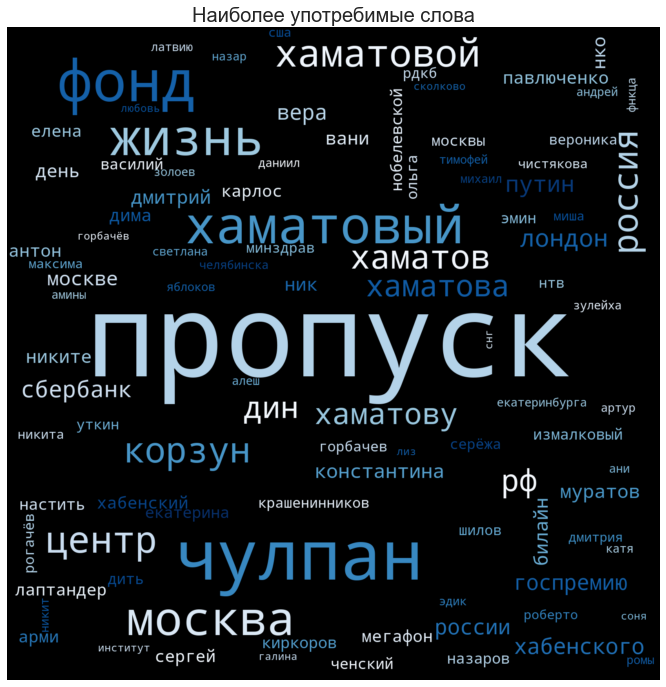

In [144]:
fig, ax = plt.subplots(1, figsize = (20, 12))

ax.imshow(wordcloud_Twitter, interpolation='bilinear')
ax.set_title('Наиболее употребимые слова', fontsize = 20)
ax.axis("off")

plt.show()

In [145]:
chulpan = ['чулпан', 'хаматовый', 'хаматовой', 'хаматов', 'хаматова', 'хаматову']
korzun = ['дин', 'корзун']
Twitter_frequence_main_object['word'] = Twitter_frequence_main_object['word'].apply(lambda x: 'чулпан' if x in chulpan else x)
Twitter_frequence_main_object['word'] = Twitter_frequence_main_object['word'].apply(lambda x: 'корзун' if x in korzun else x)

In [146]:
Twitter_frequence_main_object['percent'] = Twitter_frequence_main_object['frequency'].apply(lambda x: x/(Twitter_frequence_main['frequency'].sum()/100))
Twitter_frequence_main_object[:20].groupby(['word']).sum()

,frequency,percent
word,,
жизнь,102,0.741010
корзун,80,0.581184
лондон,21,0.152561
москва,85,0.617508
пропуск,1024,7.439157
путин,18,0.130766
россии,16,0.116237
россия,44,0.319651
рф,33,0.239738


Наиболее популярными "объектами" стали Чулпан Хаматова (примерно 17%) - соучредитель фонда, Корзун Дина Александровна (примерно 3%) - соучредитель фонда, а также Константин Хабенский (около 0.6%).  Расчет произведен с учетом общего числа твитов

Гипотезу №5 (деятельность фонда ассоциируется с определенными личностями) можно считать подтвержденной.

Из интересных упоминаний можно выделить упоминания:

Известных личностей: Киркоров, Дина Корзун, Хабенский, Путин, Муратов, Назаров, Павлюченко, Рогачев, Безруков, Горбачев

Географических мест: Москва, Россия, Латвия, Лондон, СССР

Организаций: Магафон, Сбербанк, Билайн, Гоголь-центр

### 4.5.1. Частотный анализ объектов среди токсичных твитов.

In [147]:
Twitter_object_neg = CountVectorizer(ngram_range=(1, 1))
Twitter_count_object_neg = Twitter_object_neg.fit_transform(neg_df['m5_objects'])
Twitter_frequence_object_neg = pd.DataFrame({'word':Twitter_object_neg.get_feature_names(),'frequency':np.array(Twitter_count_object_neg.sum(axis = 0))[0]}).sort_values(by = 'frequency', ascending = False)
Twitter_frequence_main_object_neg = Twitter_frequence_object_neg[:100]

In [148]:
wordcloud_Twitter = WordCloud(background_color="black",
                               colormap = 'Blues',
                               max_words=200,
                               mask=None, 
                               width=1600,
                               height=1600)\
                        .generate_from_frequencies(
                            dict(Twitter_frequence_main_object_neg.values))

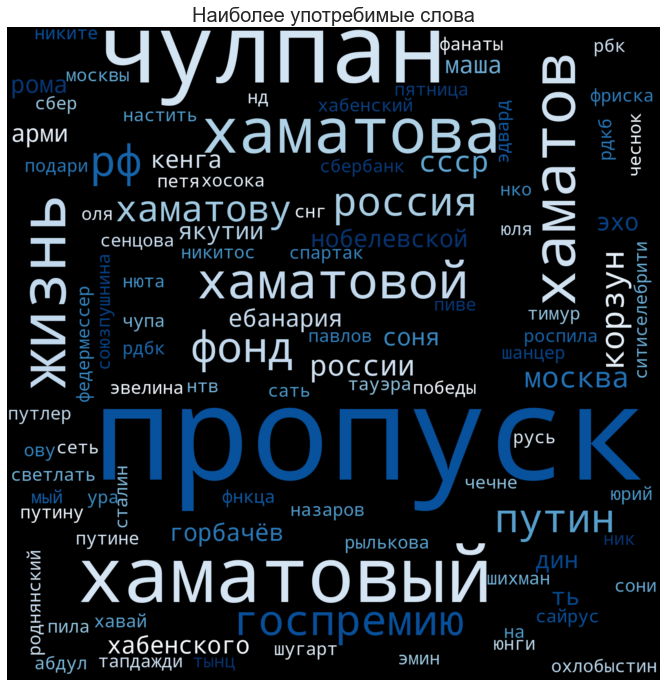

In [149]:
fig, ax = plt.subplots(1, figsize = (20, 12))

ax.imshow(wordcloud_Twitter, interpolation='bilinear')
ax.set_title('Наиболее употребимые слова', fontsize = 20)
ax.axis("off")

plt.show()

In [152]:
chulpan = ['чулпан', 'хаматовый', 'хаматовой', 'хаматов', 'хаматова', 'хаматову']
korzun = ['дин', 'корзун']
Twitter_frequence_main_object_neg['word'] = Twitter_frequence_main_object_neg['word'].apply(lambda x: 'чулпан' if x in chulpan else x)
Twitter_frequence_main_object_neg['word'] = Twitter_frequence_main_object_neg['word'].apply(lambda x: 'корзун' if x in korzun else x)

In [157]:
Twitter_frequence_main_object_neg['percent'] = Twitter_frequence_main_object_neg['frequency'].apply(lambda x: x/(Twitter_frequence_main['frequency'].sum()/100))
Twitter_frequence_main_object_neg[:20].groupby(['word']).sum()

,frequency,percent
word,,
госпремию,7,0.050854
жизнь,17,0.123502
корзун,6,0.043589
москва,3,0.021794
нобелевской,2,0.014530
пропуск,89,0.646567
путин,6,0.043589
россии,3,0.021794
россия,6,0.043589


#### Отличия между наиболее частыми "объектами" имеются, но незначительные.  Лидеры те же. Хотя редкие слова отличаются, чаще упоминаются другие личности

## 5. Анализ реакций.

### 5.1. Общий анализ.

In [216]:
# Количество лайков по всему набору данных
print(main_df.number_of_likes.sum(),main_df.number_of_likes.mean(), main_df.number_of_likes.max())

6038 2.3837347019344652 775


In [217]:
# Количество ретвитов по всему набору данных
print(main_df.number_of_retweets.sum(),main_df.number_of_retweets.mean(), main_df.number_of_retweets.max())

2988 1.1796288985392815 460


In [158]:
for_graph = main_df.groupby(['date']).sum()
for_graph

,number_of_reply,number_of_retweets,number_of_likes,r,text_lengh,is_toxic
date,,,,,,
2009,0,0,0,3,169,1
2010,0,4,1,78,5507,5
2011,8,9,4,71,5158,8
2012,52,73,14,398,29663,26
2013,45,619,49,177,13297,16
2014,43,323,63,230,17059,21
2015,20,233,64,280,21202,23
2016,16,152,277,180,13465,13
2017,71,188,323,408,29983,33


<AxesSubplot:xlabel='date', ylabel='number_of_retweets'>

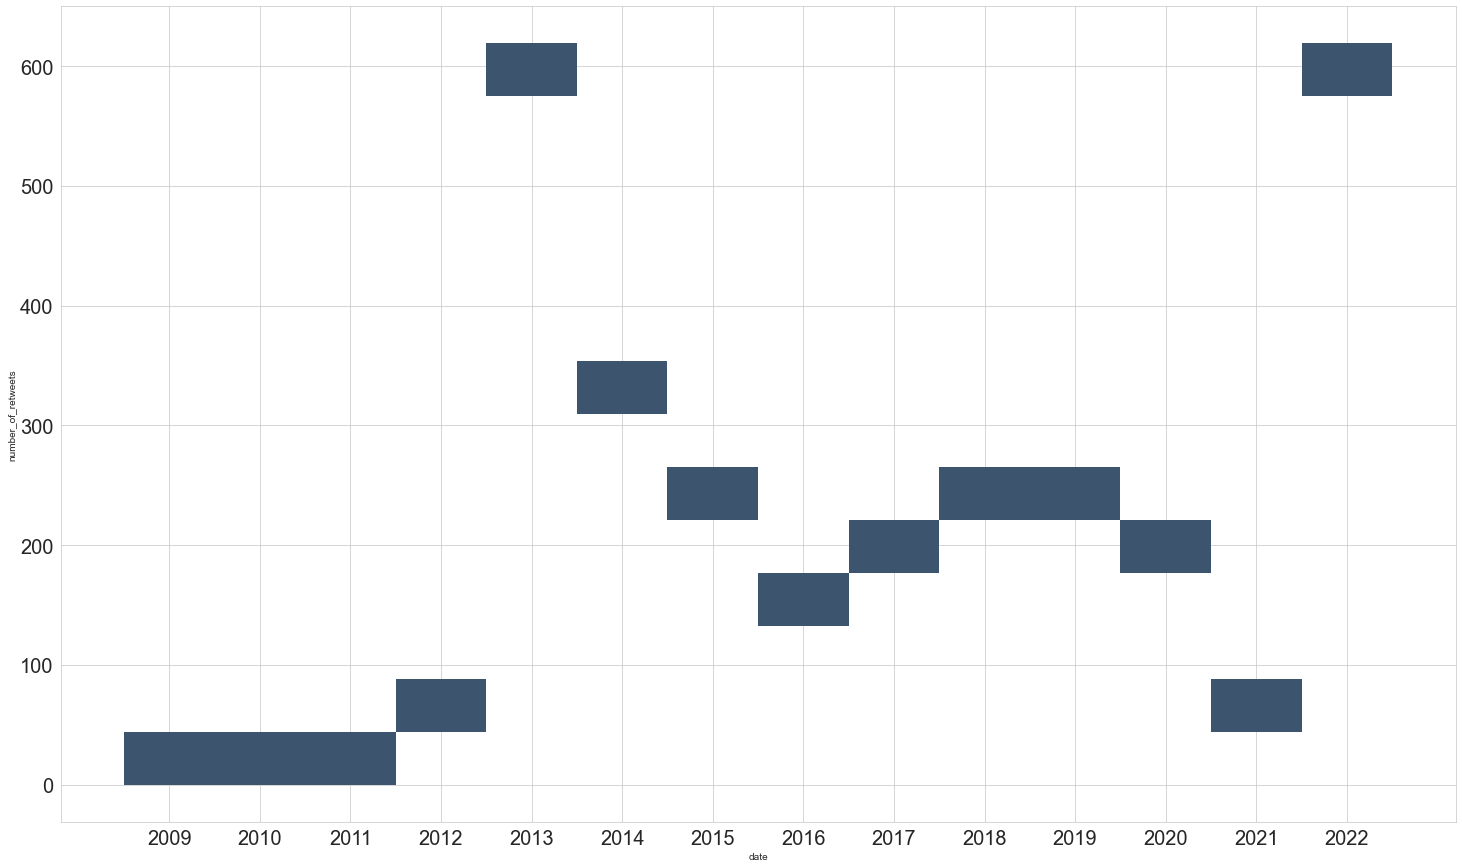

In [161]:
fig, ax = plt.subplots()
fig.set_size_inches(25,15)

sns.histplot(data=for_graph, x="date", y='number_of_retweets', bins=14)

<AxesSubplot:xlabel='date', ylabel='number_of_likes'>

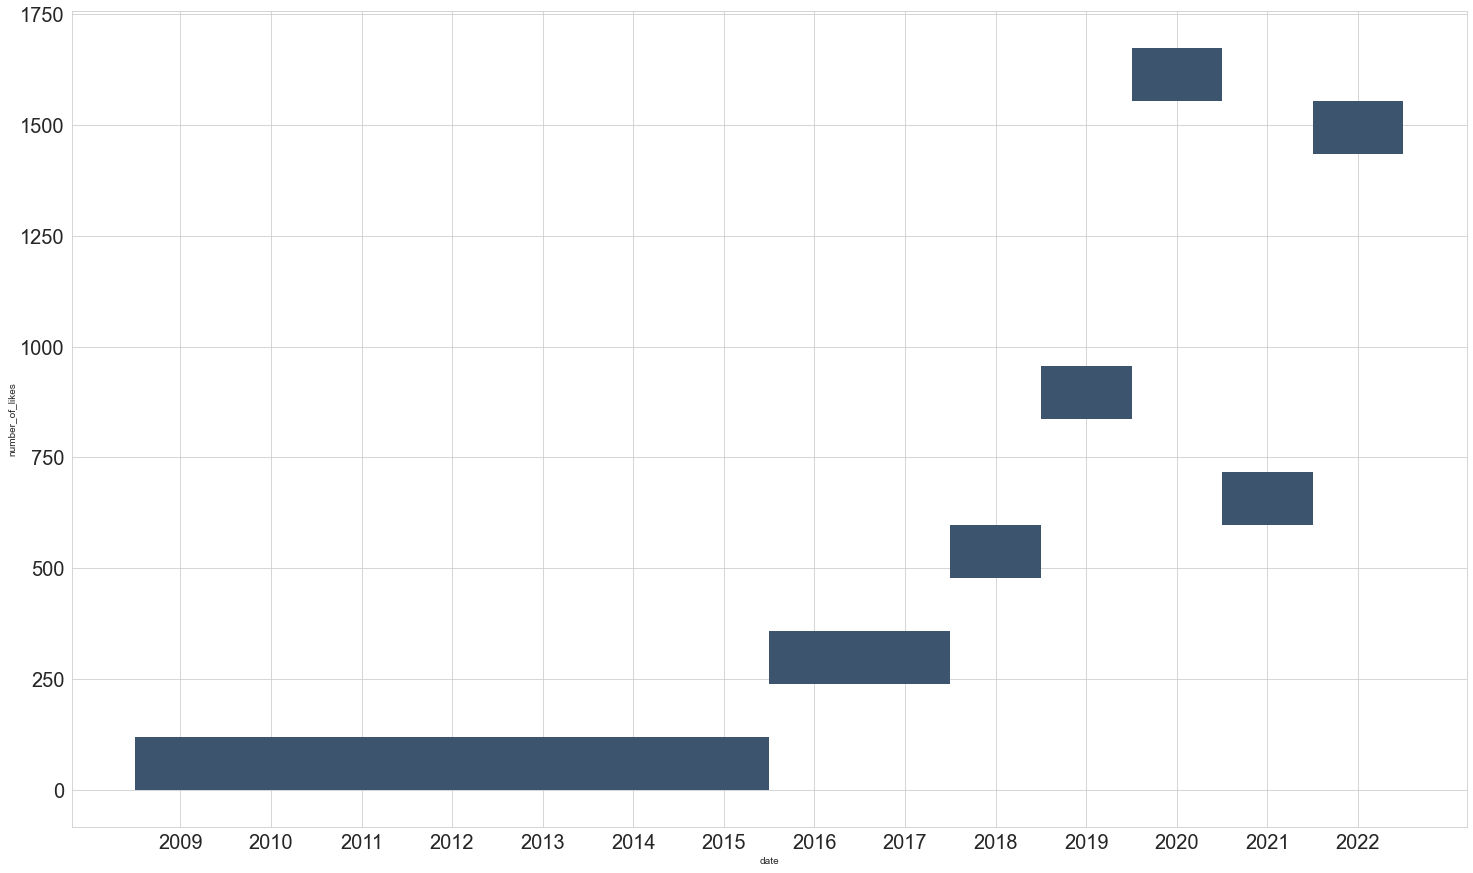

In [160]:
fig, ax = plt.subplots()
fig.set_size_inches(25,15)

sns.histplot(data=for_graph, x="date", y='number_of_likes', bins=14)

<AxesSubplot:xlabel='date', ylabel='text_lengh'>

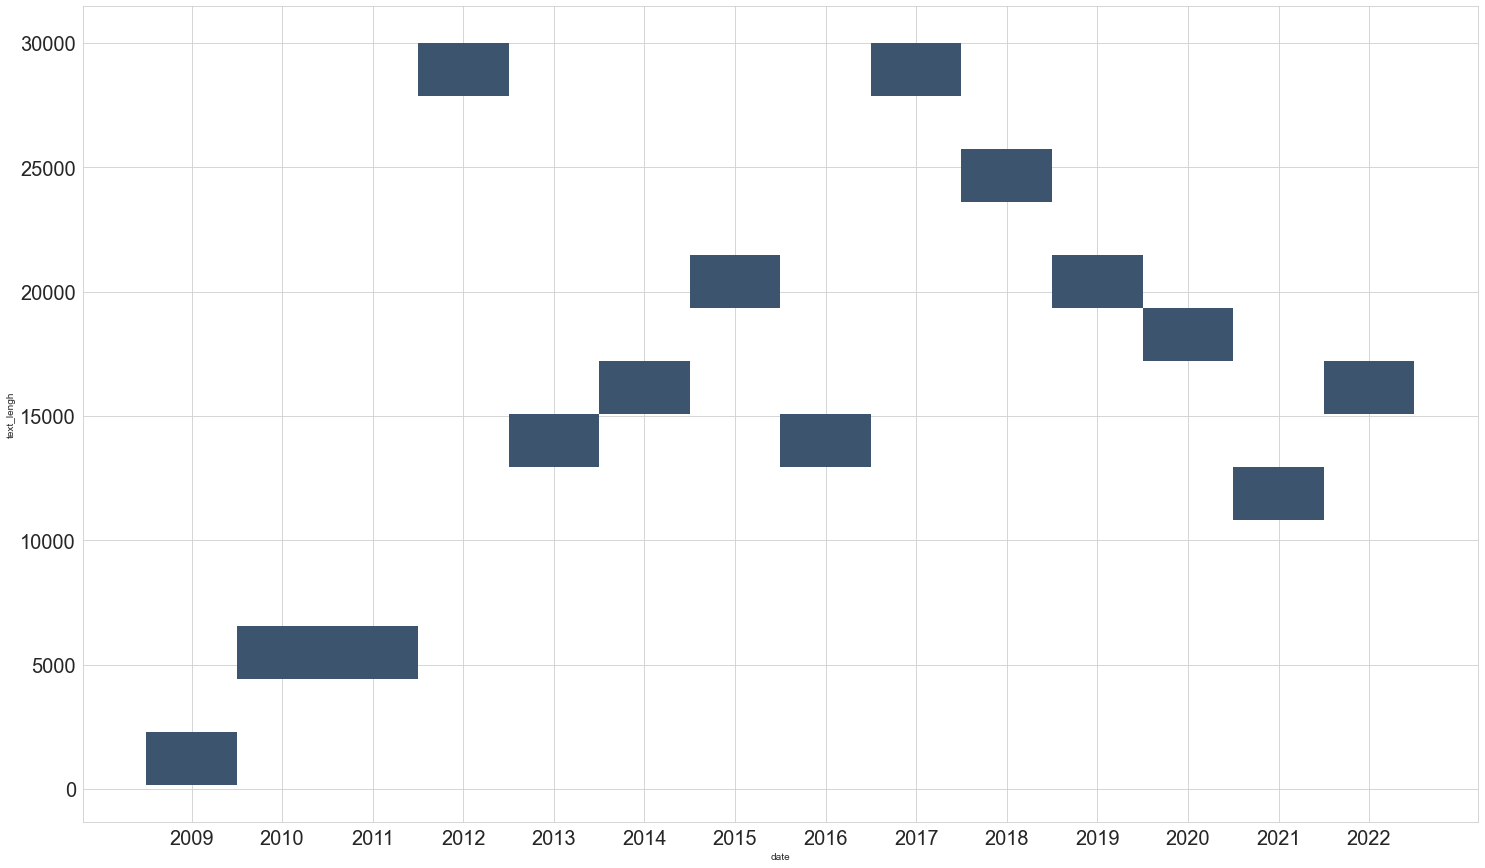

In [162]:
fig, ax = plt.subplots()
fig.set_size_inches(25,15)

sns.histplot(data=for_graph, x="date", y='text_lengh', bins=14)

#### Число лайков и ретвитов росло до 2021 года. В 2022 виден резкий рост. То же касается и числа комментариев. Суммарная длина текстовых сообщения за год росла до 2017 года включительно, после чего неукоснительно снижалась до 2021 года. В 2022 году наблюдается рост.

### 5.2. Проверка корреляции.

In [184]:
test_df = main_df.copy()

In [187]:
plt.rc('ytick', labelsize=20) 
plt.rc('xtick', labelsize=20) 

In [188]:
test_df["number_of_likes_log"] = np.log(test_df.number_of_likes)
test_df["number_of_retweets_log"] = np.log(test_df.number_of_retweets)

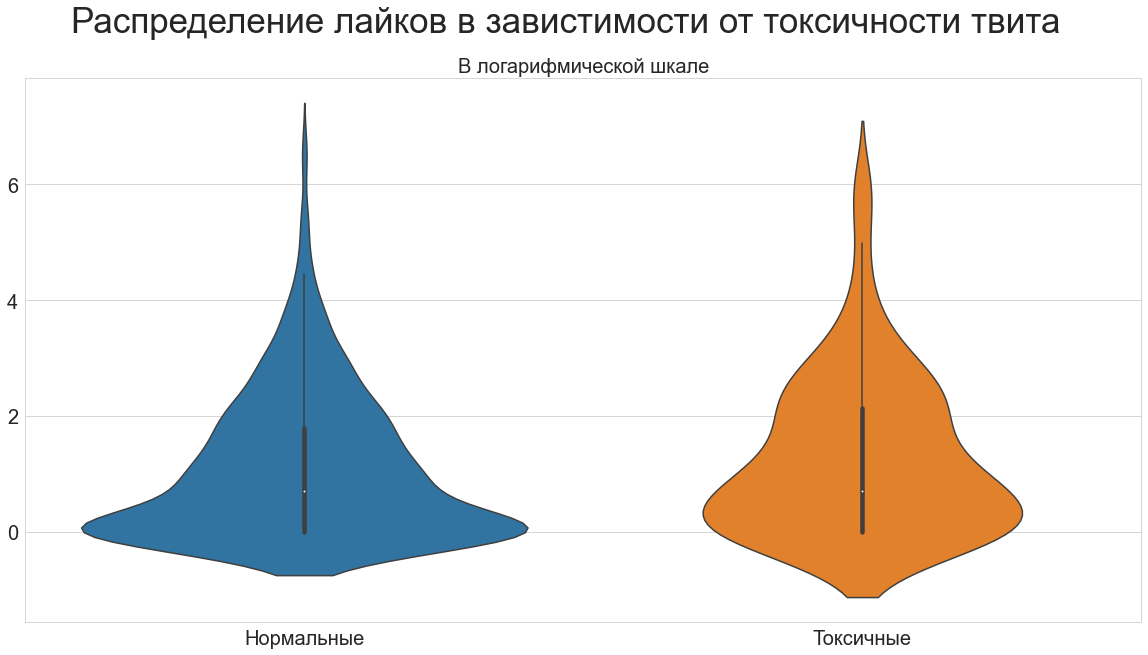

In [189]:
ax = sns.violinplot(data=test_df.loc[test_df.number_of_likes >= 1], y="number_of_likes_log", x="is_toxic");
ax.set_xticklabels(['Нормальные','Токсичные',])
plt.suptitle("Распределение лайков в завистимости от токсичности твита", fontsize=35)
plt.title("В логарифмической шкале", fontsize=20)
plt.xlabel("")
plt.ylabel("")
plt.show()

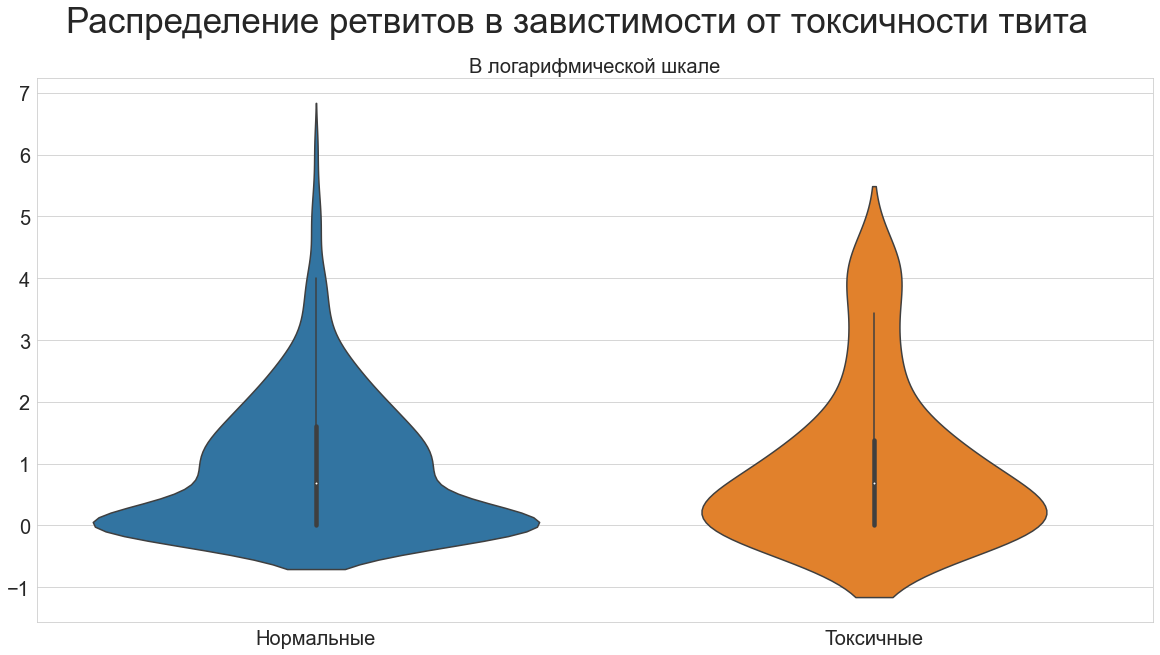

In [193]:
ax = sns.violinplot(data=test_df.loc[test_df.number_of_retweets >= 1], y="number_of_retweets_log", x="is_toxic");
ax.set_xticklabels(['Нормальные','Токсичные',])
plt.suptitle("Распределение ретвитов в завистимости от токсичности твита", fontsize=35)
plt.title("В логарифмической шкале", fontsize=20)
plt.xlabel("")
plt.ylabel("")
plt.show()

Сложно сказать опредленно, но судя по форме распределения есть неболшая сконность к тому, что токсичные комментарии чаще получают лайки и ретвиты.
Но большинство лайков и ретвитов было однано нетоксичным твитам (но их больше в выборке).

### 5.3. Проверка твитов с определенной популярностью.

#### Сообщения, имеющие минимальную популярность

In [165]:
like_df = main_df.loc[(main_df['number_of_retweets'] >=1) | (main_df["number_of_likes"] >=1)]
like_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 636 entries, 0 to 2532
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   date                636 non-null    object        
 1   text                636 non-null    object        
 2   number_of_reply     636 non-null    int64         
 3   number_of_retweets  636 non-null    int64         
 4   number_of_likes     636 non-null    int64         
 5   m5_objects          636 non-null    object        
 6   week                636 non-null    datetime64[ns]
 7   r                   636 non-null    int64         
 8   clean_text          636 non-null    object        
 9   text_lengh          636 non-null    int64         
 10  is_toxic            636 non-null    int32         
dtypes: datetime64[ns](1), int32(1), int64(5), object(4)
memory usage: 57.1+ KB


In [229]:
print(like_df.number_of_likes.sum(),like_df.number_of_likes.mean(), like_df.number_of_likes.max())

6038 9.4937106918239 775


In [230]:
print(like_df.number_of_retweets.sum(),like_df.number_of_retweets.mean(), like_df.number_of_retweets.max())

2988 4.69811320754717 460


In [172]:
Twitter = CountVectorizer(ngram_range=(1, 1))
Twitter_count_like = Twitter.fit_transform(like_df['clean_text'])
Twitter_frequence_like = pd.DataFrame({'word':Twitter.get_feature_names(),'frequency':np.array(Twitter_count_like.sum(axis = 0))[0]}).sort_values(by = 'frequency', ascending = False)
Twitter_frequence_main_like = Twitter_frequence_like[:100]

In [176]:
Twitter_frequence_main_like

,word,frequency
3537,фонд,605
876,жизнь,588
2233,подари,578
169,благотворительный,94
3683,чулпан,73
...,...,...
334,вместо,9
803,другие,9
843,ещё,9
686,детый,9


In [177]:
wordcloud_Twitter = WordCloud(background_color="black",
                               colormap = 'Blues',
                               max_words=200,
                               mask=None, 
                               width=1600,
                               height=1600)\
                        .generate_from_frequencies(
                            dict(Twitter_frequence_main_like.values))

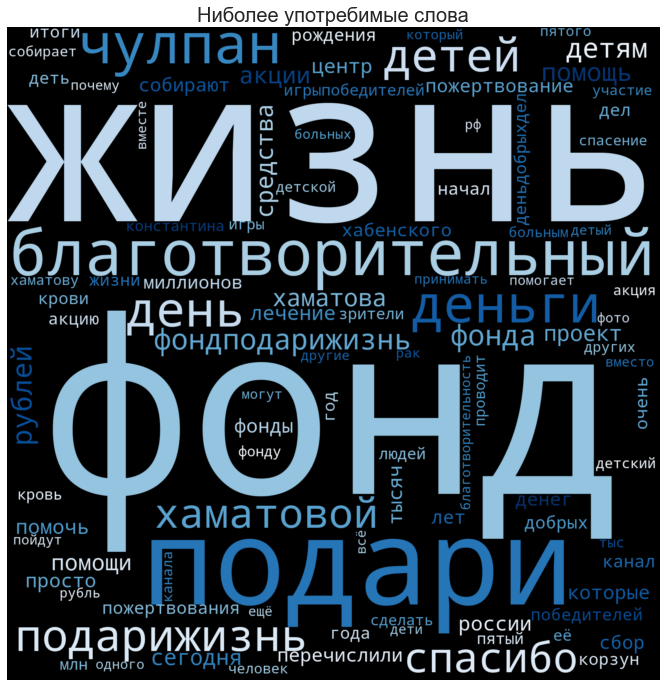

In [178]:
fig, ax = plt.subplots(1, figsize = (20, 12))

ax.imshow(wordcloud_Twitter, interpolation='bilinear')
ax.set_title('Ниболее употребимые слова', fontsize = 20)
ax.axis("off")

plt.show()

In [195]:
like_df.is_toxic.value_counts()

0    533
1    103
Name: is_toxic, dtype: int64

In [196]:
like_df_neg = like_df.loc[like_df['is_toxic']==1]

In [198]:
pd.set_option('display.max_colwidth', -1)
show_tweets(like_df_neg.loc[like_df_neg.date >= '2022'], title="Токсичные твиты незначительной популярности 2022")

In [200]:
print(like_df_neg.number_of_likes.sum(),like_df_neg.number_of_likes.mean())

1408 13.669902912621358


In [201]:
print(like_df_neg.number_of_retweets.sum(),like_df_neg.number_of_retweets.mean())

452 4.388349514563107


Можно отметить, что выявленные выше негативные отзывы довольно популярны и на порядки превосходят количество лайков и ретвитов в реднем по выборке. 

#### Средняя популярность

In [231]:
like_df_10 = like_df.loc[(like_df['number_of_retweets'] >=10) | (like_df["number_of_likes"] >=10)]
like_df_10.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 109 entries, 18 to 2523
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   date                109 non-null    object        
 1   text                109 non-null    object        
 2   number_of_reply     109 non-null    int64         
 3   number_of_retweets  109 non-null    int64         
 4   number_of_likes     109 non-null    int64         
 5   m5_objects          109 non-null    object        
 6   week                109 non-null    datetime64[ns]
 7   r                   109 non-null    int64         
 8   clean_text          109 non-null    object        
 9   text_lengh          109 non-null    int64         
 10  is_toxic            109 non-null    int32         
dtypes: datetime64[ns](1), int32(1), int64(5), object(4)
memory usage: 9.8+ KB


In [232]:
like_df_10.is_toxic.value_counts()

0    88
1    21
Name: is_toxic, dtype: int64

#### Высокая популярность

In [233]:
like_df_100 = like_df.loc[(like_df['number_of_retweets'] >=100) | (like_df["number_of_likes"] >=100)]
like_df_100.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12 entries, 362 to 2410
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   date                12 non-null     object        
 1   text                12 non-null     object        
 2   number_of_reply     12 non-null     int64         
 3   number_of_retweets  12 non-null     int64         
 4   number_of_likes     12 non-null     int64         
 5   m5_objects          12 non-null     object        
 6   week                12 non-null     datetime64[ns]
 7   r                   12 non-null     int64         
 8   clean_text          12 non-null     object        
 9   text_lengh          12 non-null     int64         
 10  is_toxic            12 non-null     int32         
dtypes: datetime64[ns](1), int32(1), int64(5), object(4)
memory usage: 1.1+ KB


In [234]:
like_df_100.is_toxic.value_counts()

0    9
1    3
Name: is_toxic, dtype: int64

In [235]:
like_df_400 = like_df.loc[(like_df['number_of_retweets'] >=400) | (like_df["number_of_likes"] >=400)]
like_df_400.is_toxic.value_counts()

0    2
Name: is_toxic, dtype: int64

Приведенная выше информация показывает, что негативные отзывы находятся среди самых популярных. Однако их число составляет лишь чсть всех отывов, которая колеблется и составляет (примерно) следующие соотношения:
для минимально популярных отзывов 1/5,
для отзывов средней популярности 1/4,
для отзывов высокой популярности 1/3.
Среди твитов популярности, приближенной к максимальной, негативные твиты отсутствуют.
Гипотезу №7 (сообщения, имеющие наибольшую реакцию, носят преимщественно позитивный характер) можно считать доказанной.

## 6. Кластеризация.

## 7. Выводы.